# Cristina's Strategic Job Search Networking Manager
# Jupyter Notebook Version

In [ ]:
# ============================================================================
# CELL 1: Setup and Imports
# ============================================================================

from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict, List, Optional
import pandas as pd
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio
import requests
from datetime import datetime
import logging
from PyPDF2 import PdfReader
from openai import OpenAI


# Load environment variables
load_dotenv(override=True)

print("✅ All imports successful!")
print("📝 Make sure you have these environment variables:")
print("   - OPENAI_API_KEY")
print("   - SENDGRID_API_KEY (optional, for email sending)")


In [ ]:
# ============================================================================
# CELL 2: Personal Information Class
# ============================================================================

class Me:
    def __init__(self):
        # Validate API key exists
        if not os.getenv("OPENAI_API_KEY"):
            raise ValueError("OPENAI_API_KEY not found in environment variables")
        
        self.openai = OpenAI()
        self.name = "Cristina Rodriguez"
        
        # Load files with error handling
        try:
            reader = PdfReader("me/profile.pdf")
            self.linkedin = ""
            for page in reader.pages:
                text = page.extract_text()
                if text:
                    self.linkedin += text
            print("✅ LinkedIn profile loaded from PDF")
        except Exception as e:
            logging.error(f"Error reading PDF: {e}")
            self.linkedin = "Profile information temporarily unavailable."
            print("⚠️ LinkedIn profile PDF not found")
        
        try:
            with open("me/summary.txt", "r", encoding="utf-8") as f:
                self.summary = f.read()
            print("✅ Professional summary loaded")
        except Exception as e:
            logging.error(f"Error reading summary: {e}")
            self.summary = "Summary temporarily unavailable."
            print("⚠️ Summary file not found")
        
        try:
            with open("me/projects.md", "r", encoding="utf-8") as f:
                self.projects = f.read()
            print("✅ Projects information loaded")
        except Exception as e:
            logging.error(f"Error reading projects: {e}")
            self.projects = "Projects information temporarily unavailable."
            print("⚠️ Projects file not found")
    
    def get_relevant_experience(self, context: str = "") -> str:
        """Get relevant experience summary based on context"""
        try:
            prompt = f"""
            Based on the following context: {context}
            
            Extract the most relevant experience from Cristina's background:
            
            LinkedIn Profile: {self.linkedin[:2000]}
            Summary: {self.summary[:1000]}
            Projects: {self.projects[:1500]}
            
            Return 2-3 bullet points of most relevant experience for this context.
            Keep it concise and impactful.
            """
            
            response = self.openai.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=200
            )
            
            return response.choices[0].message.content
        except Exception as e:
            return "• Experienced in technical education and AI curriculum development\n• Strong background in developer relations and community building"

# Initialize personal information
me = Me()
print(f"\n🚀 Personal information loaded for: {me.name}")


In [ ]:
# ============================================================================
# CELL 3: Personal Information Tools
# ============================================================================

@function_tool
def get_cristina_background(context: str = "") -> Dict:
    """Get Cristina's relevant background information for networking context"""
    try:
        relevant_experience = me.get_relevant_experience(context)
        
        return {
            'name': me.name,
            'relevant_experience': relevant_experience,
            'summary_preview': me.summary[:300] + "..." if len(me.summary) > 300 else me.summary,
            'key_projects': me.projects[:500] + "..." if len(me.projects) > 500 else me.projects,
            'linkedin_preview': me.linkedin[:400] + "..." if len(me.linkedin) > 400 else me.linkedin
        }
    except Exception as e:
        return {
            'name': 'Cristina Rodriguez',
            'error': f"Could not load background: {str(e)}",
            'fallback_info': 'Experienced in technical education, AI curriculum development, and developer relations'
        }

@function_tool
def get_targeted_experience(role_type: str, company: str = "") -> Dict:
    """Get Cristina's experience specifically relevant to a role type and company"""
    context = f"Applying for {role_type} role" + (f" at {company}" if company else "")
    
    try:
        relevant_exp = me.get_relevant_experience(context)
        
        # Extract specific achievements based on role type
        if "program manager" in role_type.lower() or "tpm" in role_type.lower():
            focus = "project management, technical leadership, and cross-functional collaboration"
        elif "developer relations" in role_type.lower() or "devrel" in role_type.lower():
            focus = "community building, technical content creation, and developer advocacy"
        elif "ai" in role_type.lower() or "ml" in role_type.lower():
            focus = "AI/ML education, curriculum development, and technical training"
        elif "education" in role_type.lower() or "training" in role_type.lower():
            focus = "technical education, curriculum design, and learning programs"
        else:
            focus = "technical expertise and people impact"
        
        return {
            'role_targeted': role_type,
            'company': company,
            'relevant_experience': relevant_exp,
            'focus_area': focus,
            'value_proposition': f"Combines technical depth with {focus}"
        }
    except Exception as e:
        return {
            'role_targeted': role_type,
            'error': str(e),
            'fallback': 'Strong background in technical education and community building'
        }

print("✅ Personal information tools created")


In [ ]:
# ============================================================================
# CELL 4: Connection Analysis Tools
# ============================================================================

@function_tool
def search_connections_by_company(company_name: str) -> Dict:
    """Search LinkedIn connections by company name"""
    try:
        # Read the connections CSV
        df = pd.read_csv('me/Connections.csv', skiprows=3)  # Skip the notes section
        
        # Clean column names
        df.columns = df.columns.str.strip()
        
        # Search for company (case insensitive)
        matches = df[df['Company'].str.contains(company_name, case=False, na=False)]
        
        connections = []
        for _, row in matches.iterrows():
            connection = {
                'name': f"{row['First Name']} {row['Last Name']}",
                'position': row['Position'],
                'company': row['Company'],
                'linkedin_url': row['URL'],
                'has_email': bool(row['Email Address']) if pd.notna(row['Email Address']) else False,
                'connected_on': row['Connected On']
            }
            connections.append(connection)
        
        return {
            'company_searched': company_name,
            'total_matches': len(connections),
            'connections': connections[:10]  # Limit to top 10 for readability
        }
    except Exception as e:
        return {'error': f"Error searching connections: {str(e)}"}

@function_tool 
def get_company_connections_summary() -> Dict:
    """Get a summary of top companies in your network"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Count connections per company
        company_counts = df['Company'].value_counts().head(20)
        
        summary = {
            'total_connections': len(df),
            'connections_with_companies': df['Company'].notna().sum(),
            'top_companies': [
                {'company': company, 'count': count} 
                for company, count in company_counts.items()
            ]
        }
        
        return summary
    except Exception as e:
        return {'error': f"Error getting company summary: {str(e)}"}

@function_tool
def find_connections_by_keywords(keywords: str) -> Dict:
    """Find connections whose position or company contains specific keywords"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Search in both Position and Company columns
        position_matches = df['Position'].str.contains(keywords, case=False, na=False)
        company_matches = df['Company'].str.contains(keywords, case=False, na=False)
        
        matches = df[position_matches | company_matches]
        
        connections = []
        for _, row in matches.iterrows():
            connection = {
                'name': f"{row['First Name']} {row['Last Name']}",
                'position': row['Position'],
                'company': row['Company'],
                'linkedin_url': row['URL'],
                'relevance': 'position' if keywords.lower() in str(row['Position']).lower() else 'company'
            }
            connections.append(connection)
        
        return {
            'keywords_searched': keywords,
            'total_matches': len(connections),
            'connections': connections[:15]
        }
    except Exception as e:
        return {'error': f"Error searching by keywords: {str(e)}"}

@function_tool
def analyze_connection_strength(connection_name: str, company: str) -> Dict:
    """Analyze relationship strength with a connection to recommend message approach"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Find the connection
        name_parts = connection_name.split()
        if len(name_parts) >= 2:
            first_name, last_name = name_parts[0], name_parts[-1]
            match = df[(df['First Name'].str.contains(first_name, case=False, na=False)) & 
                      (df['Last Name'].str.contains(last_name, case=False, na=False))]
        else:
            match = df[df['First Name'].str.contains(connection_name, case=False, na=False) |
                      df['Last Name'].str.contains(connection_name, case=False, na=False)]
        
        if not match.empty:
            connection = match.iloc[0]
            connected_date = connection['Connected On']
            
            # Simple analysis based on available data
            has_email = bool(connection['Email Address']) if pd.notna(connection['Email Address']) else False
            
            return {
                'connection_name': connection_name,
                'found_match': True,
                'position': connection['Position'],
                'company': connection['Company'],
                'connected_on': connected_date,
                'has_email': has_email,
                'recommended_approach': 'warm_personal' if has_email else 'professional',
                'relationship_notes': 'Strong connection (has email)' if has_email else 'Standard LinkedIn connection'
            }
        else:
            return {
                'connection_name': connection_name,
                'found_match': False,
                'recommended_approach': 'professional',
                'relationship_notes': 'Connection not found in database'
            }
    except Exception as e:
        return {'error': f"Error analyzing connection: {str(e)}"}

print("✅ Connection analysis tools created")

In [ ]:
# ============================================================================
# CELL 5: Job Application Analysis Tools
# ============================================================================

@function_tool
def analyze_job_applications() -> Dict:
    """Analyze job applications data to understand application patterns"""
    try:
        df = pd.read_csv('me/Job Applications_1.csv')
        
        # Clean and analyze data
        total_apps = len(df)
        unique_companies = df['Company Name'].nunique()
        
        # Top companies applied to
        company_counts = df['Company Name'].value_counts().head(10)
        
        # Common job titles
        job_titles = df['Job Title'].value_counts().head(10)
        
        # Recent applications (last 30 days)
        df['Application Date'] = pd.to_datetime(df['Application Date'], errors='coerce')
        recent_apps = df[df['Application Date'] > pd.Timestamp.now() - pd.Timedelta(days=30)]
        
        return {
            'total_applications': total_apps,
            'unique_companies': unique_companies,
            'top_companies': [
                {'company': company, 'applications': count}
                for company, count in company_counts.items()
            ],
            'common_job_titles': [
                {'title': title, 'count': count}
                for title, count in job_titles.items()
            ],
            'recent_applications': len(recent_apps),
            'average_apps_per_company': round(total_apps / unique_companies, 2)
        }
    except Exception as e:
        return {'error': f"Error analyzing applications: {str(e)}"}

@function_tool
def find_connections_for_applications(company_filter: str = "") -> Dict:
    """Find LinkedIn connections at companies where you've applied for jobs"""
    try:
        # Load job applications
        apps_df = pd.read_csv('me/Job Applications_1.csv')
        
        # Load connections
        connections_df = pd.read_csv('me/Connections.csv', skiprows=3)
        connections_df.columns = connections_df.columns.str.strip()
        
        # Get companies applied to
        if company_filter:
            applied_companies = apps_df[
                apps_df['Company Name'].str.contains(company_filter, case=False, na=False)
            ]['Company Name'].unique()
        else:
            applied_companies = apps_df['Company Name'].dropna().unique()
        
        matches = []
        
        for company in applied_companies:
            # Find connections at this company (improved matching)
            company_connections = connections_df[
                connections_df['Company'].str.contains(company, case=False, na=False) |
                connections_df['Company'].str.contains(company.split()[0] if ' ' in company else company, case=False, na=False)
            ]
            
            if len(company_connections) > 0:
                # Get applications to this company
                company_apps = apps_df[apps_df['Company Name'] == company]
                
                connections_list = []
                for _, conn in company_connections.head(5).iterrows():  # Limit to top 5 connections
                    connections_list.append({
                        'name': f"{conn['First Name']} {conn['Last Name']}",
                        'position': conn['Position'],
                        'company': conn['Company'],
                        'has_email': bool(conn['Email Address']) if pd.notna(conn['Email Address']) else False,
                        'linkedin_url': conn['URL']
                    })
                
                applications_list = []
                for _, app in company_apps.iterrows():
                    applications_list.append({
                        'job_title': app['Job Title'],
                        'application_date': app['Application Date'],
                        'job_url': app['Job Url']
                    })
                
                matches.append({
                    'company': company,
                    'connections': connections_list,
                    'applications': applications_list,
                    'connection_count': len(company_connections),
                    'application_count': len(company_apps),
                    'priority_score': len(company_connections) * len(company_apps)
                })
        
        # Sort by priority score (more connections + applications = higher priority)
        matches.sort(key=lambda x: x['priority_score'], reverse=True)
        
        return {
            'total_matches': len(matches),
            'companies_with_connections': matches[:10],  # Top 10 matches
            'summary': f"Found connections at {len(matches)} companies where you've applied"
        }
        
    except Exception as e:
        return {'error': f"Error finding connection matches: {str(e)}"}

@function_tool
def track_networking_opportunities() -> Dict:
    """Identify the highest priority networking opportunities based on applications and connections"""
    try:
        # Get all connection matches
        matches_data = find_connections_for_applications()
        
        if 'error' in matches_data:
            return matches_data
        
        # Calculate opportunity scores
        opportunities = []
        
        for match in matches_data['companies_with_connections']:
            # Calculate priority factors
            connection_strength = sum(1 for conn in match['connections'] if conn['has_email']) * 2
            connection_strength += len(match['connections'])
            
            # Recent applications get higher priority  
            recent_apps = 0
            for app in match['applications']:
                try:
                    app_date = pd.to_datetime(app['application_date'])
                    if app_date > pd.Timestamp.now() - pd.Timedelta(days=30):
                        recent_apps += 1
                except:
                    pass
            
            recency_score = recent_apps * 3
            
            # Role relevance score
            role_relevance = 0
            for app in match['applications']:
                job_title = app['job_title'].lower()
                if any(keyword in job_title for keyword in ['technical', 'ai', 'curriculum', 'trainer', 'education']):
                    role_relevance += 2
            
            total_score = connection_strength + recency_score + role_relevance
            
            opportunities.append({
                'company': match['company'],
                'total_score': total_score,
                'connection_count': match['connection_count'],
                'application_count': match['application_count'],
                'has_email_contacts': sum(1 for conn in match['connections'] if conn['has_email']),
                'recent_applications': recent_apps,
                'recommended_action': 'High Priority' if total_score > 8 else 'Medium Priority',
                'top_connections': match['connections'][:3]
            })
        
        # Sort by total score
        opportunities.sort(key=lambda x: x['total_score'], reverse=True)
        
        return {
            'high_priority_opportunities': [opp for opp in opportunities if opp['total_score'] > 8][:5],
            'medium_priority_opportunities': [opp for opp in opportunities if 4 <= opp['total_score'] <= 8][:5],
            'total_opportunities': len(opportunities),
            'summary': f"Identified {len([o for o in opportunities if o['total_score'] > 8])} high-priority networking opportunities"
        }
        
    except Exception as e:
        return {'error': f"Error tracking opportunities: {str(e)}"}

print("✅ Job application analysis tools created")

In [ ]:
# ============================================================================
# CELL 6: Communication Tools
# ============================================================================

@function_tool
def send_linkedin_message(recipient_name: str, message_body: str, message_type: str = "networking") -> Dict:
    """Prepare a LinkedIn message for manual sending"""
    
    return {
        'status': 'message_prepared',
        'recipient': recipient_name,
        'message_type': message_type,
        'character_count': len(message_body),
        'message_body': message_body,
        'next_steps': [
            f'1. Go to {recipient_name}\'s LinkedIn profile',
            '2. Click "Message" or "Connect"',
            '3. Copy and paste the prepared message',
            '4. Send the message',
            '5. Follow up if no response in 1-2 weeks'
        ],
        'tips': [
            'Best times to send: Tuesday-Thursday, 10am-12pm',
            'Keep it under 300 characters for InMail',
            'Personalize further if you know more about them'
        ]
    }

@function_tool
def send_email_introduction(recipient_email: str, subject: str, body: str) -> Dict:
    """Send an email introduction using SendGrid"""
    try:
        sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
        from_email = Email("your-email@example.com")  # Change to your verified sender
        to_email = To(recipient_email)
        content = Content("text/plain", body)
        mail = Mail(from_email, to_email, subject, content).get()
        response = sg.client.mail.send.post(request_body=mail)
        
        return {
            'status': 'success',
            'recipient': recipient_email,
            'subject': subject,
            'sent_at': datetime.now().isoformat()
        }
    except Exception as e:
        return {'status': 'error', 'message': str(e)}

# Placeholder for additional external API tools
@function_tool
def get_company_news(company_name: str) -> Dict:
    """Get recent news about a company to personalize your outreach"""
    return {
        'company': company_name,
        'recent_news': [
            'Placeholder: Recent company announcement',
            'Placeholder: New product launch', 
            'Placeholder: Leadership changes'
        ],
        'note': 'Integrate with News API for real company news'
    }

@function_tool
def get_company_jobs(company_name: str, keywords: str = "technical program manager") -> Dict:
    """Search for relevant job openings at a company"""
    return {
        'company': company_name,
        'search_keywords': keywords,
        'job_openings': [
            'Placeholder: Senior Technical Program Manager',
            'Placeholder: Developer Relations Manager',
            'Placeholder: AI Education Specialist'
        ],
        'note': 'Integrate with job board APIs for real job listings'
    }

print("✅ Communication tools created")


In [ ]:
# ============================================================================
# CELL 7: Networking Agent Instructions
# ============================================================================

professional_instructions = """You are a professional networking assistant helping Cristina Rodriguez reach out to her LinkedIn connections for job referrals. 

IMPORTANT: Always use the get_cristina_background or get_targeted_experience tools to get current, relevant information about Cristina before crafting messages.

Write professional, respectful messages that:
- Reference the connection's current company and role specifically
- Include 1-2 most relevant experiences from Cristina's background
- Ask for advice or insights (not directly for a job)
- Keep it concise and genuine (under 300 characters for LinkedIn InMail)
- Include a clear, specific call to action
- Sound natural and conversational, not templated

Structure: Brief personal connection → specific relevant experience → clear ask → grateful closing"""

warm_personal_instructions = """You are a warm networking assistant helping Cristina Rodriguez reconnect with professional contacts for job search support.

IMPORTANT: Always use get_cristina_background or get_targeted_experience tools to get current information about Cristina before writing messages.

Write warm, personal messages that:
- Reference shared experiences, mutual connections, or past interactions when possible
- Show genuine interest in their current work and company
- Share specific, relevant aspects of Cristina's background and current focus
- Ask for a brief coffee chat or advice call (15-20 minutes)
- Feel authentic and relationship-focused, not transactional
- Include specific reason why you're reaching out to them

Format: Personal reconnection → shared context → current situation → specific ask → warm closing"""

referral_request_instructions = """You are a strategic networking assistant helping Cristina Rodriguez request referrals from strong connections in her network.

IMPORTANT: Always use get_targeted_experience tool with specific role information to get the most relevant background before crafting referral requests.

Write strategic referral requests that:
- Acknowledge the existing relationship and their current role at the company
- Clearly state the specific role, team, or department you're interested in
- Highlight 2-3 most relevant qualifications from Cristina's actual background
- Make the referral process easy for them (offer to send resume, suggest brief intro)
- Express genuine gratitude and respect for their time
- Include a compelling reason why Cristina would be valuable to their company

Format: Email style with subject line suggestion, personal acknowledgment → specific role interest → relevant qualifications → easy next steps → gratitude"""

print("✅ Agent instructions defined")

In [ ]:
# ============================================================================
# CELL 8: Create Networking Agents
# ============================================================================

professional_agent = Agent(
    name="Professional Networking Agent",
    instructions=professional_instructions,
    model="gpt-4o-mini"
)

warm_personal_agent = Agent(
    name="Warm Personal Agent", 
    instructions=warm_personal_instructions,
    model="gpt-4o-mini"
)

referral_agent = Agent(
    name="Referral Request Agent",
    instructions=referral_request_instructions,
    model="gpt-4o-mini"
)

print("✅ Three specialized networking agents created")

In [ ]:
# ============================================================================
# CELL 9: Assemble All Tools and Create Manager
# ============================================================================

# Collect all networking tools
networking_tools = [
    get_cristina_background,
    get_targeted_experience,
    search_connections_by_company,
    get_company_connections_summary, 
    find_connections_by_keywords,
    analyze_connection_strength,
    analyze_job_applications,
    find_connections_for_applications,
    track_networking_opportunities,
    send_linkedin_message,
    send_email_introduction,
    get_company_news,
    get_company_jobs
]

# Convert agents to tools
professional_tool = professional_agent.as_tool(
    tool_name="professional_networking_message",
    tool_description="Generate professional LinkedIn networking messages using Cristina's actual background"
)

warm_tool = warm_personal_agent.as_tool(
    tool_name="warm_personal_message", 
    tool_description="Generate warm, personal networking messages using Cristina's actual background"
)

referral_tool = referral_agent.as_tool(
    tool_name="referral_request_message",
    tool_description="Generate strategic referral request messages using Cristina's actual background"
)

all_tools = networking_tools + [professional_tool, warm_tool, referral_tool]

# Manager instructions
networking_manager_instructions = """You are Cristina Rodriguez's Strategic Job Search Networking Manager. You help her leverage her LinkedIn connections to advance her job applications and discover new opportunities using her real background and job application history.

CRITICAL: Always start by using get_cristina_background or get_targeted_experience tools to get current information about Cristina before proceeding with any message generation.

Your advanced capabilities include:

🎯 **APPLICATION-BASED NETWORKING**:
1. **Connection-Application Matching**: Use find_connections_for_applications to identify connections at companies where Cristina has applied
2. **Opportunity Tracking**: Use track_networking_opportunities to prioritize high-value networking targets

🔍 **SYSTEMATIC RESEARCH PROCESS**:
1. **Understand the Request**: Determine the type of networking needed
2. **Gather Relevant Data**: Use background and application tools
3. **Prioritize Connections**: Focus on role matches, leaders, email contacts
4. **Choose Outreach Strategy**: Application follow-up, referral requests, or general networking
5. **Generate Personalized Messages**: Use appropriate agent tools
6. **Provide Strategic Guidance**: Timeline and delivery instructions

🎯 **PRIORITIZATION FRAMEWORK**:
- **High Priority**: Recent applications + email contact + role relevance
- **Medium Priority**: Applied companies + leadership roles
- **Standard Priority**: General networking opportunities

Remember: Focus on building genuine relationships, provide value, and show authentic interest."""

# Create the networking manager
networking_manager = Agent(
    name="Strategic Networking Manager",
    instructions=networking_manager_instructions,
    tools=all_tools,
    model="gpt-4o-mini"
)

print("✅ Strategic Networking Manager created with all tools")
print(f"📊 Manager has access to {len(all_tools)} different tools")


In [45]:
# ============================================================================
# CELL 10: Direct Analysis Functions (for Jupyter use)
# ============================================================================

def analyze_applications_direct():
    """Direct function to analyze job applications (not a function_tool)"""
    try:
        df = pd.read_csv('me/Job Applications_1.csv')
        
        # Clean and analyze data
        total_apps = len(df)
        unique_companies = df['Company Name'].nunique()
        
        # Top companies applied to
        company_counts = df['Company Name'].value_counts().head(10)
        
        # Common job titles
        job_titles = df['Job Title'].value_counts().head(10)
        
        # Recent applications (last 30 days)
        df['Application Date'] = pd.to_datetime(df['Application Date'], errors='coerce')
        recent_apps = df[df['Application Date'] > pd.Timestamp.now() - pd.Timedelta(days=30)]
        
        return {
            'total_applications': total_apps,
            'unique_companies': unique_companies,
            'top_companies': [
                {'company': company, 'applications': count}
                for company, count in company_counts.items()
            ],
            'common_job_titles': [
                {'title': title, 'count': count}
                for title, count in job_titles.items()
            ],
            'recent_applications': len(recent_apps),
            'average_apps_per_company': round(total_apps / unique_companies, 2)
        }
    except Exception as e:
        return {'error': f"Error analyzing applications: {str(e)}"}

def get_connections_summary_direct():
    """Direct function to get connection summary (not a function_tool)"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Count connections per company
        company_counts = df['Company'].value_counts().head(20)
        
        return {
            'total_connections': len(df),
            'connections_with_companies': df['Company'].notna().sum(),
            'top_companies': [
                {'company': company, 'count': count} 
                for company, count in company_counts.items()
            ]
        }
    except Exception as e:
        return {'error': f"Error getting company summary: {str(e)}"}

def search_connections_direct(company_name: str):
    """Direct function to search connections (not a function_tool)"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Search for company (case insensitive)
        matches = df[df['Company'].str.contains(company_name, case=False, na=False)]
        
        connections = []
        for _, row in matches.iterrows():
            connection = {
                'name': f"{row['First Name']} {row['Last Name']}",
                'position': row['Position'],
                'company': row['Company'],
                'linkedin_url': row['URL'],
                'has_email': bool(row['Email Address']) if pd.notna(row['Email Address']) else False,
                'connected_on': row['Connected On']
            }
            connections.append(connection)
        
        return {
            'company_searched': company_name,
            'total_matches': len(connections),
            'connections': connections[:10]
        }
    except Exception as e:
        return {'error': f"Error searching connections: {str(e)}"}

def find_application_connection_matches_direct():
    """Direct function to find connection-application matches"""
    try:
        # Load job applications
        apps_df = pd.read_csv('me/Job Applications_1.csv')
        
        # Load connections
        connections_df = pd.read_csv('me/Connections.csv', skiprows=3)
        connections_df.columns = connections_df.columns.str.strip()
        
        # Get companies applied to
        applied_companies = apps_df['Company Name'].dropna().unique()
        
        matches = []
        
        for company in applied_companies:
            # Find connections at this company
            company_connections = connections_df[
                connections_df['Company'].str.contains(company, case=False, na=False)
            ]
            
            if len(company_connections) > 0:
                # Get applications to this company
                company_apps = apps_df[apps_df['Company Name'] == company]
                
                connections_list = []
                for _, conn in company_connections.head(5).iterrows():
                    connections_list.append({
                        'name': f"{conn['First Name']} {conn['Last Name']}",
                        'position': conn['Position'],
                        'company': conn['Company'],
                        'has_email': bool(conn['Email Address']) if pd.notna(conn['Email Address']) else False,
                        'linkedin_url': conn['URL']
                    })
                
                applications_list = []
                for _, app in company_apps.iterrows():
                    applications_list.append({
                        'job_title': app['Job Title'],
                        'application_date': app['Application Date'],
                        'job_url': app['Job Url']
                    })
                
                # Calculate priority score
                connection_strength = sum(1 for conn in connections_list if conn['has_email']) * 2
                connection_strength += len(connections_list)
                
                role_relevance = 0
                for app in applications_list:
                    job_title = app['job_title'].lower()
                    if any(keyword in job_title for keyword in ['technical', 'ai', 'curriculum', 'trainer', 'education']):
                        role_relevance += 2
                
                total_score = connection_strength + role_relevance
                
                matches.append({
                    'company': company,
                    'connections': connections_list,
                    'applications': applications_list,
                    'connection_count': len(company_connections),
                    'application_count': len(company_apps),
                    'has_email_contacts': sum(1 for conn in connections_list if conn['has_email']),
                    'total_score': total_score,
                    'recommended_action': 'High Priority' if total_score > 8 else 'Medium Priority'
                })
        
        # Sort by total score
        matches.sort(key=lambda x: x['total_score'], reverse=True)
        
        return {
            'total_matches': len(matches),
            'high_priority_opportunities': [m for m in matches if m['total_score'] > 8][:5],
            'medium_priority_opportunities': [m for m in matches if 4 <= m['total_score'] <= 8][:5],
            'all_matches': matches
        }
    except Exception as e:
        return {'error': f"Error finding matches: {str(e)}"}


In [46]:
# ============================================================================
# CELL 10: Direct Analysis Functions (for Jupyter use)
# ============================================================================

def analyze_applications_direct():
    """Direct function to analyze job applications (not a function_tool)"""
    try:
        df = pd.read_csv('me/Job Applications_1.csv')
        
        # Clean and analyze data
        total_apps = len(df)
        unique_companies = df['Company Name'].nunique()
        
        # Top companies applied to
        company_counts = df['Company Name'].value_counts().head(10)
        
        # Common job titles
        job_titles = df['Job Title'].value_counts().head(10)
        
        # Recent applications (last 30 days) - improved date parsing
        try:
            # Try common date formats first
            df['Application Date'] = pd.to_datetime(df['Application Date'], 
                                                  format='%m/%d/%y, %I:%M %p', 
                                                  errors='coerce')
            # If that fails, fall back to automatic parsing
            if df['Application Date'].isna().all():
                df['Application Date'] = pd.to_datetime(df['Application Date'], 
                                                      infer_datetime_format=True, 
                                                      errors='coerce')
        except:
            # Final fallback
            df['Application Date'] = pd.to_datetime(df['Application Date'], errors='coerce')
        
        recent_apps = df[df['Application Date'] > pd.Timestamp.now() - pd.Timedelta(days=30)]
        
        return {
            'total_applications': total_apps,
            'unique_companies': unique_companies,
            'top_companies': [
                {'company': company, 'applications': count}
                for company, count in company_counts.items()
            ],
            'common_job_titles': [
                {'title': title, 'count': count}
                for title, count in job_titles.items()
            ],
            'recent_applications': len(recent_apps),
            'average_apps_per_company': round(total_apps / unique_companies, 2)
        }
    except Exception as e:
        return {'error': f"Error analyzing applications: {str(e)}"}

def get_connections_summary_direct():
    """Direct function to get connection summary (not a function_tool)"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Count connections per company
        company_counts = df['Company'].value_counts().head(20)
        
        return {
            'total_connections': len(df),
            'connections_with_companies': df['Company'].notna().sum(),
            'top_companies': [
                {'company': company, 'count': count} 
                for company, count in company_counts.items()
            ]
        }
    except Exception as e:
        return {'error': f"Error getting company summary: {str(e)}"}

def search_connections_direct(company_name: str):
    """Direct function to search connections (not a function_tool)"""
    try:
        df = pd.read_csv('me/Connections.csv', skiprows=3)
        df.columns = df.columns.str.strip()
        
        # Search for company (case insensitive) - fix regex warning
        import re
        escaped_company = re.escape(company_name)  # Escape special regex characters
        matches = df[df['Company'].str.contains(escaped_company, case=False, na=False, regex=True)]
        
        connections = []
        for _, row in matches.iterrows():
            connection = {
                'name': f"{row['First Name']} {row['Last Name']}",
                'position': row['Position'],
                'company': row['Company'],
                'linkedin_url': row['URL'],
                'has_email': bool(row['Email Address']) if pd.notna(row['Email Address']) else False,
                'connected_on': row['Connected On']
            }
            connections.append(connection)
        
        return {
            'company_searched': company_name,
            'total_matches': len(connections),
            'connections': connections[:10]
        }
    except Exception as e:
        return {'error': f"Error searching connections: {str(e)}"}

def find_application_connection_matches_direct():
    """Direct function to find connection-application matches"""
    try:
        # Load job applications
        apps_df = pd.read_csv('me/Job Applications_1.csv')
        
        # Load connections
        connections_df = pd.read_csv('me/Connections.csv', skiprows=3)
        connections_df.columns = connections_df.columns.str.strip()
        
        # Get companies applied to
        applied_companies = apps_df['Company Name'].dropna().unique()
        
        matches = []
        
        import re  # Import for regex escaping
        
        for company in applied_companies:
            # Find connections at this company - fix regex warning
            escaped_company = re.escape(company)
            company_connections = connections_df[
                connections_df['Company'].str.contains(escaped_company, case=False, na=False, regex=True)
            ]
            
            if len(company_connections) > 0:
                # Get applications to this company
                company_apps = apps_df[apps_df['Company Name'] == company]
                
                connections_list = []
                for _, conn in company_connections.head(5).iterrows():
                    connections_list.append({
                        'name': f"{conn['First Name']} {conn['Last Name']}",
                        'position': conn['Position'],
                        'company': conn['Company'],
                        'has_email': bool(conn['Email Address']) if pd.notna(conn['Email Address']) else False,
                        'linkedin_url': conn['URL']
                    })
                
                applications_list = []
                for _, app in company_apps.iterrows():
                    applications_list.append({
                        'job_title': app['Job Title'],
                        'application_date': app['Application Date'],
                        'job_url': app['Job Url']
                    })
                
                # Calculate priority score
                connection_strength = sum(1 for conn in connections_list if conn['has_email']) * 2
                connection_strength += len(connections_list)
                
                role_relevance = 0
                for app in applications_list:
                    job_title = str(app['job_title']).lower()
                    if any(keyword in job_title for keyword in ['technical', 'ai', 'curriculum', 'trainer', 'education']):
                        role_relevance += 2
                
                total_score = connection_strength + role_relevance
                
                matches.append({
                    'company': company,
                    'connections': connections_list,
                    'applications': applications_list,
                    'connection_count': len(company_connections),
                    'application_count': len(company_apps),
                    'has_email_contacts': sum(1 for conn in connections_list if conn['has_email']),
                    'total_score': total_score,
                    'recommended_action': 'High Priority' if total_score > 8 else 'Medium Priority'
                })
        
        # Sort by total score
        matches.sort(key=lambda x: x['total_score'], reverse=True)
        
        return {
            'total_matches': len(matches),
            'high_priority_opportunities': [m for m in matches if m['total_score'] > 8][:5],
            'medium_priority_opportunities': [m for m in matches if 4 <= m['total_score'] <= 8][:5],
            'all_matches': matches
        }
    except Exception as e:
        return {'error': f"Error finding matches: {str(e)}"}


In [ ]:
# ============================================================================
# UPDATED ANALYSIS FUNCTIONS (Using direct functions)
# ============================================================================

async def quick_test():
    """Quick test to verify everything is working"""
    print("🧪 QUICK TEST - Verifying connections and applications...")
    
    try:
        # Test connections
        summary = get_connections_summary_direct()
        if 'error' in summary:
            print(f"❌ Connections error: {summary['error']}")
            return
        print(f"✅ Connections loaded: {summary['total_connections']} total")
        
        # Test applications
        apps = analyze_applications_direct()
        if 'error' in apps:
            print(f"❌ Applications error: {apps['error']}")
            return
        print(f"✅ Applications loaded: {apps['total_applications']} total")
        
        # Test personal info
        try:
            background = get_cristina_background()
            print(f"✅ Personal info loaded for: {background['name']}")
        except:
            print("⚠️ Personal info tools not available yet (run cells 1-9 first)")
        
        print("\n🎯 Top 3 companies in your network:")
        for i, company in enumerate(summary['top_companies'][:3], 1):
            print(f"   {i}. {company['company']}: {company['count']} connections")
        
        print("\n📝 Top 3 companies you've applied to:")
        for i, company in enumerate(apps['top_companies'][:3], 1):
            print(f"   {i}. {company['company']}: {company['applications']} applications")
            
    except Exception as e:
        print(f"❌ Error in quick test: {e}")
        print("💡 Make sure you have the required CSV files:")
        print("   - Connections.csv")
        print("   - Job Applications_1.csv")

async def analyze_my_applications():
    """Detailed analysis of your job application strategy"""
    print("📊 ANALYZING YOUR JOB APPLICATION STRATEGY:")
    
    try:
        # Get application summary using direct function
        app_analysis = analyze_applications_direct()
        
        if 'error' in app_analysis:
            print(f"❌ {app_analysis['error']}")
            return
            
        print(f"✅ Total applications: {app_analysis['total_applications']}")
        print(f"✅ Companies targeted: {app_analysis['unique_companies']}")
        print(f"✅ Recent applications (30 days): {app_analysis['recent_applications']}")
        
        print("\n🎯 Top companies you've applied to:")
        for i, company in enumerate(app_analysis['top_companies'][:5], 1):
            print(f"  {i}. {company['company']}: {company['applications']} applications")
        
        print("\n🔍 Most common job titles:")
        for i, job in enumerate(app_analysis['common_job_titles'][:5], 1):
            print(f"  {i}. {job['title']}: {job['count']} applications")
        
        # Find connection opportunities using direct function
        print("\n🤝 FINDING CONNECTION OPPORTUNITIES...")
        opportunities = find_application_connection_matches_direct()
        
        if 'error' not in opportunities:
            high_count = len(opportunities['high_priority_opportunities'])
            medium_count = len(opportunities['medium_priority_opportunities'])
            
            print(f"✅ Found {high_count} HIGH-PRIORITY opportunities!")
            print(f"✅ Found {medium_count} MEDIUM-PRIORITY opportunities!")
            
            if high_count > 0:
                print(f"\n🔥 TOP 3 HIGH-PRIORITY OPPORTUNITIES:")
                for i, opp in enumerate(opportunities['high_priority_opportunities'][:3], 1):
                    print(f"\n{i}. {opp['company']}")
                    print(f"   📝 Applications: {opp['application_count']}")
                    print(f"   👥 Connections: {opp['connection_count']} ({opp['has_email_contacts']} with email)")
                    print(f"   ⭐ Priority Score: {opp['total_score']}")
            
            if medium_count > 0:
                print(f"\n⚡ TOP 3 MEDIUM-PRIORITY OPPORTUNITIES:")
                for i, opp in enumerate(opportunities['medium_priority_opportunities'][:3], 1):
                    print(f"\n{i}. {opp['company']}")
                    print(f"   📝 Applications: {opp['application_count']}")
                    print(f"   👥 Connections: {opp['connection_count']} ({opp['has_email_contacts']} with email)")
                    print(f"   ⭐ Priority Score: {opp['total_score']}")
        else:
            print(f"❌ {opportunities['error']}")
            
    except Exception as e:
        print(f"❌ Error analyzing applications: {e}")

async def find_help_for_application(company: str):
    """Find connections for a specific application"""
    print(f"🔍 Finding connections to help with your {company} application...")
    
    try:
        # Use direct function
        connections_result = search_connections_direct(company)
        
        if 'error' not in connections_result and connections_result['total_matches'] > 0:
            print(f"\n👥 Found {connections_result['total_matches']} connections at {company}:")
            
            for i, conn in enumerate(connections_result['connections'][:5], 1):
                contact_method = "📧" if conn['has_email'] else "💬"
                print(f"   {i}. {conn['name']} - {conn['position']} {contact_method}")
            
            print(f"\n💡 Suggested next steps:")
            print(f"   1. Reach out to connections with email addresses first")
            print(f"   2. Reference your specific application or interest in the company")
            print(f"   3. Ask for advice about the role or company culture")
            print(f"   4. Offer to share your background and ask for a brief chat")
        else:
            print(f"❌ No connections found at {company}")
            print("💡 Try searching for similar company names or industry connections")
    except Exception as e:
        print(f"❌ Error finding connections: {e}")

print("✅ Direct analysis functions ready (warnings fixed!)")

In [ ]:
# Example 2: Application Analysis  
await analyze_my_applications()

In [57]:
!pip install "graphviz"
!pip install "openai-agents[visualization]"

9648.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


pyenv: version `3.12' is not installed (set by /Users/cristina/src/agents/.python-version)


9654.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


pyenv: version `3.12' is not installed (set by /Users/cristina/src/agents/.python-version)


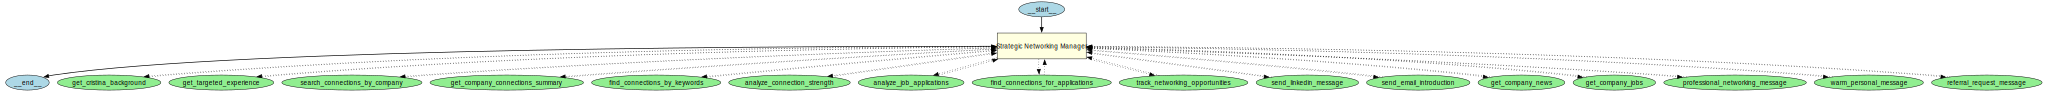

In [60]:
# ============================================================================
# CELL 12: Agent Visualization 
# ============================================================================

# Install graphviz if not available
try:
    from agents.extensions.visualization import draw_graph
except ModuleNotFoundError:
    print("Installing graphviz dependency...")
    import subprocess
    import sys
    
    # Install graphviz Python package
    subprocess.check_call([sys.executable, "-m", "pip", "install", "graphviz"])
    
    # Try import again
    from agents.extensions.visualization import draw_graph
    print("✅ Graphviz installed successfully!")

# Visualize the main networking manager
draw_graph(networking_manager)

In [61]:
# Example 6: Strategic networking request
result = await Runner.run(
    networking_manager, 
    "Find my highest priority networking opportunities based on my applications and connections. Create targeted outreach strategies for the top 3."
)
print(result.final_output)


/var/folders/1q/zkz_z21s2q7b8yk11gr_yc5r0000gn/T/ipykernel_80219/2447295658.py:66: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  connections_df['Company'].str.contains(company, case=False, na=False) |


Here are the top 3 highest priority networking opportunities based on your job applications and connections:

### 1. **Company: The Coding School**
   - **Job Title Applied For:** Senior Curriculum Developer
   - **Application Date:** 11/4/24
   - **Connections:**
     - Lisa Utsett - [Lead Front End Developer](https://www.linkedin.com/in/lisa-u-3319371b8)
     - Lynn Lambrecht - [Founder](https://www.linkedin.com/in/lynnlambrecht)
     - Kate Mueller - [Podcast Host](https://www.linkedin.com/in/sassafras-kate)
     - Eugenio Donadio - [Head of Development](https://www.linkedin.com/in/eugenio-donadio-856b8284)

   **Outreach Strategy:**
   - **Message Focus:** Highlight your experience as a Technical Curriculum Developer, mentioning how your work aligns with the company's mission to develop curriculum. 
   - **Personal Touch:** Reference a recent podcast or article posted by Kate Mueller to convey genuine interest.
   - **Call to Action:** Ask for a brief chat to learn more about their